## 隶属于系列： <font color='green'>*Python for financial analysis*</font>

### Main confuse...
如果您打算启动一个新的投资组合，并且为了保持收益的稳定性，您不想在组合中拥有两只高度相关的股票，该怎么办？ 
### Intuitively, you may be do this:

In [2]:
import pandas as pd
import numpy as np
A_price=np.random.randint(5,7,25).tolist()+np.linspace(5,3,5).tolist()+np.random.randint(3,5,30).tolist() # 60 days
B_price=np.random.randint(15,19,25).tolist()+np.linspace(15,11,5).tolist()+np.random.randint(11,15,30).tolist() # 60 days
shares_info={'A_price':A_price,'B_price':B_price}
correlation=pd.DataFrame(shares_info).corr()
correlation

,A_price,B_price
A_price,1.000000,0.839786
B_price,0.839786,1.000000


 你发现，股票A和股票B的相关系数为0.7822，属于高度相关！你决定在投资组合中不能同时选择它们。

#### 但是，其实A和B仅仅只有5个交易日高度相关（可能这5天是因为特朗普搞事，把大盘集体搞趴了~），依据这样的结果去做决策就不那么明智了！  
看看另外55个交易日A和B的相关性就知道了，其实他们并不是高度相关的：

In [3]:
shares_info={'A_price_prev25':A_price[:25],'B_price_prev25':B_price[:25]}
correlation=pd.DataFrame(shares_info).corr()
correlation

,A_price_prev25,B_price_prev25
A_price_prev25,1.000000,0.156259
B_price_prev25,0.156259,1.000000


In [4]:
shares_info={'A_price_last30':A_price[31:],'B_price_last30':B_price[31:]}
correlation=pd.DataFrame(shares_info).corr()
correlation

,A_price_last30,B_price_last30
A_price_last30,1.000000,0.354592
B_price_last30,0.354592,1.000000


#### 观察A和B的价格曲线，也看不出有过多的相关性~  那么现在怎么办？

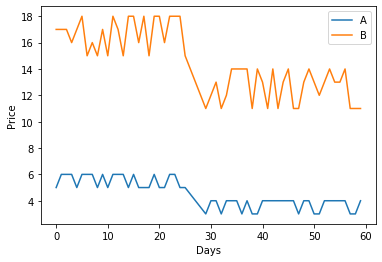

In [6]:
import matplotlib.pyplot as plt
plt.plot(A_price,label='A')
plt.plot(B_price,label='B')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

### **进入主题：**
利用每日的分时价格数据，计算A和B每个交易日的分时波动相关性，然后把各个交易日的相关性做成曲线，这样就能看到<font color='green'>A和B的相关性趋势了</font>！

使用到的API：
- ts.get_tick_data 获取每日分时数据
- ts.get_hist_data 获取日期序列

In [7]:
import tushare as ts
SH=ts.get_tick_data('600030','2020-11-26',src='tt')
SH.head()

,time,price,change,volume,amount,type
0,09:25:02,29.21,-0.01,5748,16789908,买盘
1,09:30:02,29.22,0.01,704,2056483,买盘
2,09:30:05,29.21,-0.01,2034,5944753,卖盘
3,09:30:07,29.25,0.04,1343,3923051,买盘
4,09:30:11,29.25,0.00,147,429996,卖盘


In [8]:
dates=ts.get_hist_data('sh',start='2020-08-02',end='2020-11-24').index[::-1]
dates[:5]

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


Index(['2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07'], dtype='object', name='date')

### 开始动手

直接上代码了···

In [9]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tqdm
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False

class Storage:
    """存储类：用来存储或读取拉取过的分时数据，节省以后再次使用时的运行时间"""
    def __init__(self,code_date_ticks={}):
        self._code_date_ticks=code_date_ticks   # format {code_date:ticks}
    def set_ticks(self,code_date='',ticks=None):
        self._code_date_ticks[code_date]=ticks
    def get_ticks(self,code_date=''):
        if code_date not in self._code_date_ticks:
            return False
        return self._code_date_ticks[code_date]
    def dump(self,ticks_file_name=None):
        """ticks_file_name:str like ticks file name./n
           Funtional:object cache dumps to file
        """
        f=open(ticks_file_name,'wb')
        pickle.dump(self._code_date_ticks,f)
        f.close()
    def load(self,ticks_file_name=None):
        """ticks_file_name:str like ticks file name./n
           Functional: local cache loads to object.
        """
        f=open(ticks_file_name,'rb')
        self._code_date_ticks=pickle.load(f)
        f.close()
    def show_storage(self):
        return self._code_date_ticks
class Correlation:
    """计算类：用于计算每日分时相关性，组成逐日的序列，并进行曲线平滑处理"""
    def __init__(self):
        self._legal_dates=[] # for plot purepose
        self._codes_info=''
        self._corrs=[]
        self._cache=Storage()
    def compute_day_corr(self,codeA='',codeB='',date=''):
        self._codes_info=codeA+'_'+codeB
        combA=codeA+'_'+date
        combB=codeB+'_'+date
        ##--------------------------------
        if self._cache.get_ticks(combA) is False:
            #print('New Record:%s'%combA)
            A=ts.get_tick_data(codeA,date,src='tt') # call API
            if A is None:return False            # skip Null resource  
            A_price=A['price']
            self._cache.set_ticks(combA,A_price) # pd.series
        else:
            #print('Read Record:%s'%combA)
            A_price=self._cache.get_ticks(combA)
        ##--------------------------------
        if self._cache.get_ticks(combB) is False:
            #print('New Record:%s'%combB)
            B=ts.get_tick_data(codeB,date,src='tt') # call API
            if B is None:return False            # skip Null resource  
            B_price=B['price']
            self._cache.set_ticks(combB,B_price) # pd.series
        else:
            #print('Read Record:%s'%combB)
            B_price=self._cache.get_ticks(combB)
        ##---------------------------------
        self._legal_dates.append(date) # only legal date comes here
        comb=pd.DataFrame({codeA:A_price,codeB:B_price}) #in DataFrame format for corr. compute purpose
        return comb.corr().iloc[0,1]
    def compute_corrs_along_day(self,codeA='',codeB='',dates=None):
        """target:str --target code \n base:str --base code \n dates:sequens"""
        self._legal_dates=[] # refresh legal dates for each call
        corrs_along_day=[]
        print('Processing %s_%s ...'%(codeA,codeB),end='*')
        for d in tqdm.tqdm(dates):
            corr=self.compute_day_corr(codeA,codeB,d)
            if corr is not False:
                corrs_along_day.append(corr)
        #smooth curve
        self._corrs=self.smooth_corrs(corrs_along_day)
        return self._legal_dates,self._corrs
    def smooth_corrs(self,lis=[]):
        """Exponentially weighted averges"""
        v,v_lis,beta=0,[],0.9
        for i in range(1,len(lis)+1):
            v=beta*v+(1-beta)*lis[i-1]
            v_bias=v/(1-beta**i)
            v_lis.append(v_bias)
        return v_lis
    def plot_corrs(self):
        codeA,codeB=self._codes_info.split('_')
        plt.plot(self._corrs,label='%s-%s Corr.'%(codeA,codeB))
        plt.legend(loc='best', shadow=True, fontsize='x-large')
        plt.grid()
        plt.xlabel('date',fontsize='x-large')
        plt.ylabel('Corr.',fontsize='x-large')
        plt.xticks(range(len(self._legal_dates)),self._legal_dates,rotation=45,fontproperties='STKAITI')
        plt.title('Corrs. Curve by day with Exponentially Weighted Averges',fontsize='x-large')
        plt.savefig('corrs_%s.png'%self._codes_info)   
    def call_dump(self,ticks_file_name=None):
        self._cache.dump(ticks_file_name)
    def call_load(self,ticks_file_name=None):
        self._cache.load(ticks_file_name)
    def call_storage(self):
        return self._cache.show_storage()

### 使用指南~  
找个对象···定个日子···

In [10]:
C=Correlation() #找个对象先！
dates=ts.get_hist_data('sh',start='2020-05-02',end='2020-11-24').index[::-1].values #再定个日子！

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


计算一下这俩娃：兆易创新和长电科技 dates这段时间以来的相关性···

In [11]:
t,corrs=C.compute_corrs_along_day('603986','600584',dates) 

Processing 603986_600584 ...*

100%|████████████████████████████████████████████████████████████████████████████████| 137/137 [01:27<00:00,  1.56it/s]


有两种方式进行可视化:
- 利用返回值可视化：plt.plot(t,corrs)
- 利用内置函数可视化：C.plot_corrs()

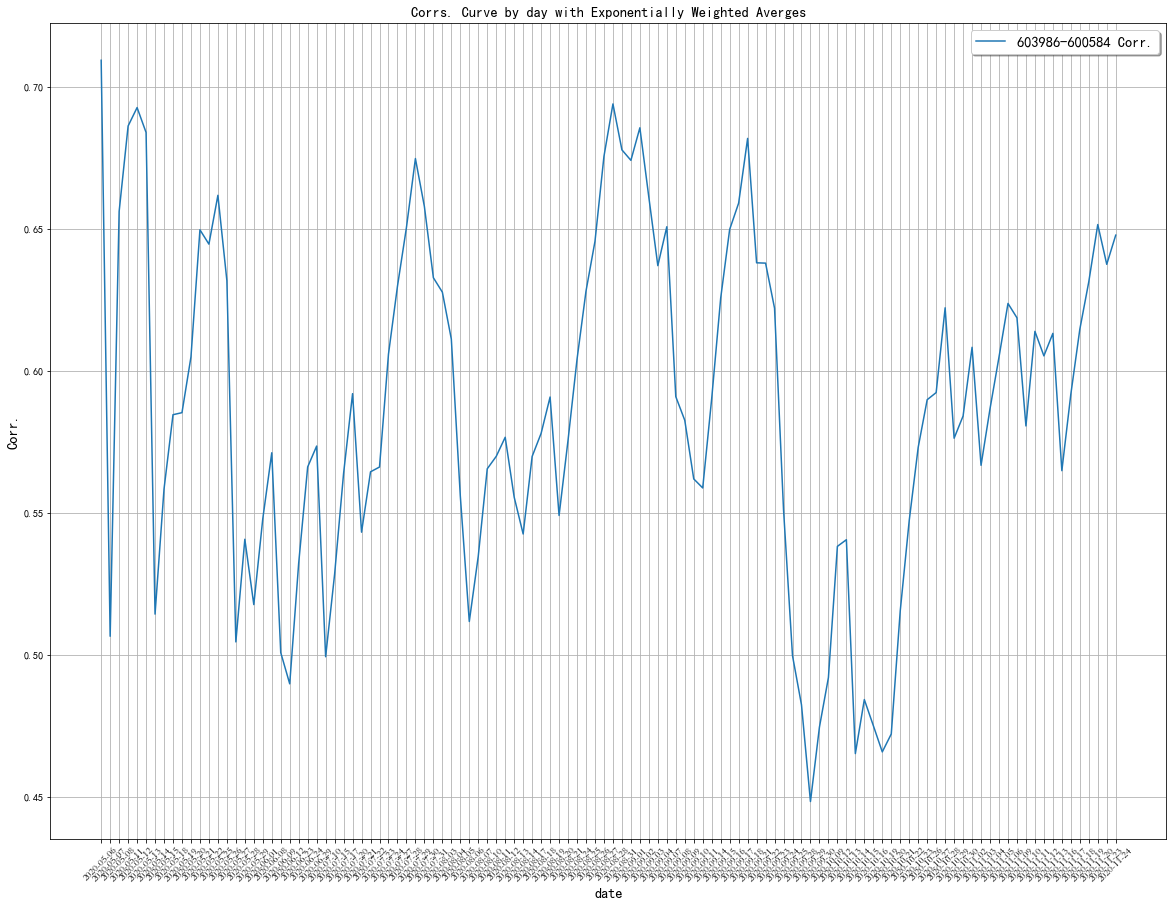

In [12]:
C.plot_corrs()

**可以看到兆易创新和长电科技 一直以来都具有高度的相关性，基本上大于0.5**  
所以，现在你可以在投资组合里只保留其中一个就可以了！腾出来的money选个别的行业吧···

**<font color='green'>存储抓取过的分时数据**  </font>  
再用兆易创新或长电科技跟别的股票计算相关性时，就可以省去大量时间了···

In [13]:
C.call_dump('ticks_datas')

In [ ]:
# 查看Storage类中的存储
C.call_storage()

**过了几天，你想再看一下兆易创新和长电科技的相关性曲线，load上次dump在本地的数据，会节省绝大部分时间哦···**  
<font color='green'>首次计算用时:1分27秒，本次用时仅3秒！</font>

In [14]:
D=Correlation() #找个对象先！
dates=ts.get_hist_data('sh',start='2020-05-02',end='2020-11-26').index[::-1].values # 过了2天
# load local data
D.call_load('ticks_datas')
t,corrs=D.compute_corrs_along_day('603986','600584',dates) 

  0%|                                                                                          | 0/139 [00:00<?, ?it/s]

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
Processing 603986_600584 ...*

100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:03<00:00, 37.82it/s]


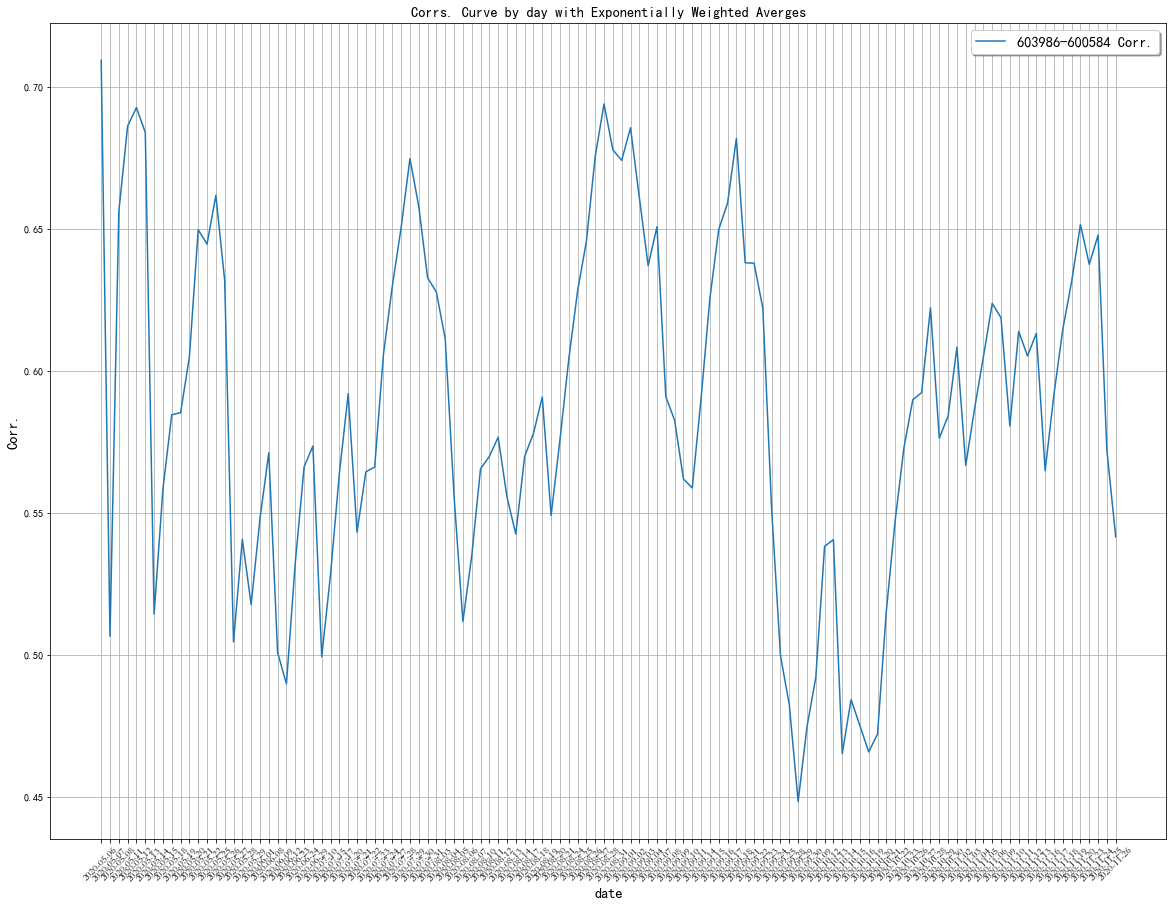

In [15]:
D.plot_corrs()

### Tips :
- 内置函数 smooth_corrs 真的很重要 用了它会如丝般顺滑啊···
- 不信的话可以用self._corrs=corrs_along_day 代替self._corrs=self.smooth_corrs(corrs_along_day) 试试看

  0%|                                                                                          | 0/139 [00:00<?, ?it/s]

Processing 603986_000568 ...*

100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:45<00:00,  3.02it/s]


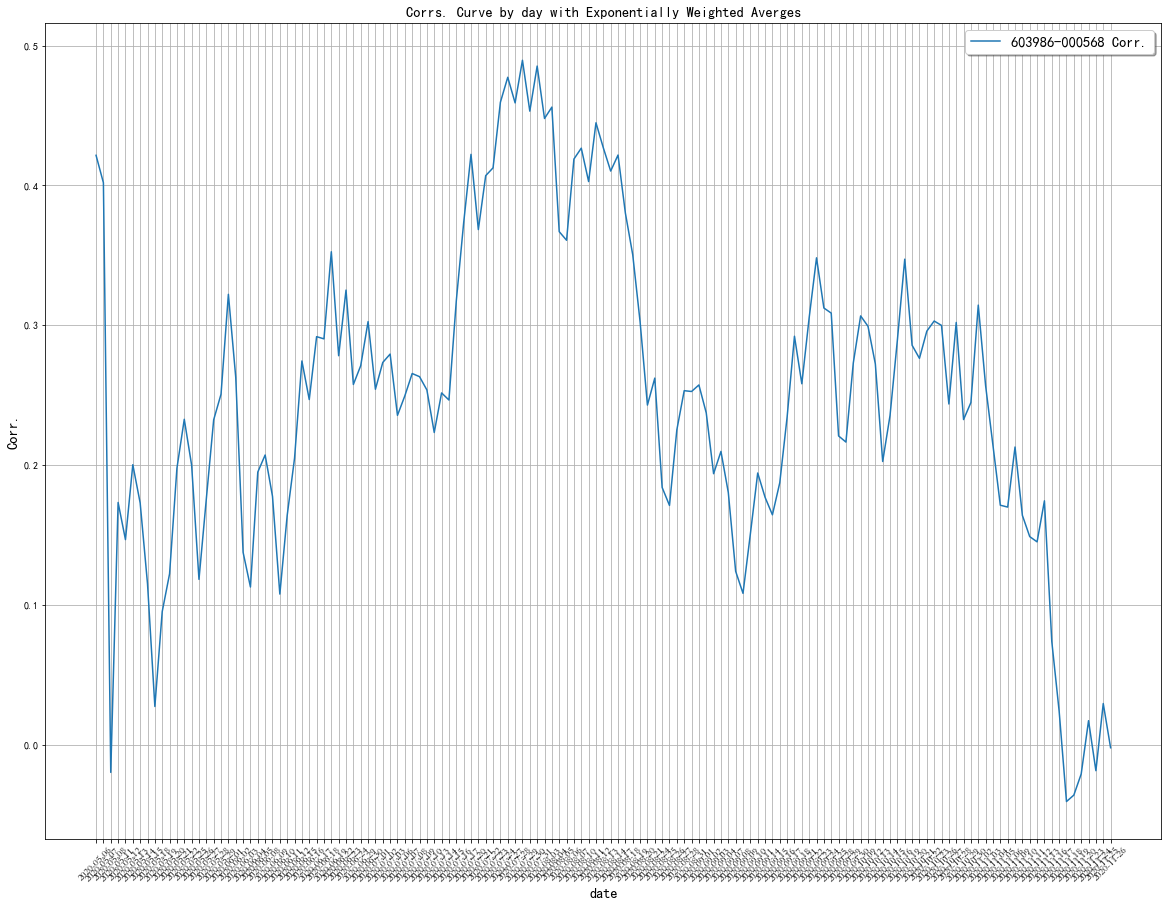

In [16]:
#试试科技与白酒  貌似最近它们有角色互换的趋势···
t,corrs=D.compute_corrs_along_day('603986','000568',dates)
D.plot_corrs()